In [1]:
# Tensorflow / Keras
from tensorflow import keras # for building Neural Networks
print('Tensorflow/Keras: %s' % keras.__version__) # print version
from keras.models import Sequential # for creating a linear stack of layers for our Neural Network
from keras import Input # for instantiating a keras tensor
from keras.layers import Masking,Bidirectional, LSTM, RepeatVector, Dense, TimeDistributed,MaxPooling1D, Flatten, Conv1D,Conv2D,Dropout, MaxPooling2D # for creating layers inside the Neural Network
from keras.optimizers import Adam , SGD
# Data manipulation
import pandas as pd # for data manipulation
print('pandas: %s' % pd.__version__) # print version
import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version

# Sklearn
import sklearn
print('sklearn: %s' % sklearn.__version__) # print version
from sklearn.preprocessing import MinMaxScaler # for feature scaling
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model
# Visualization
import plotly 
import plotly.express as px
import plotly.graph_objects as go
print('plotly: %s' % plotly.__version__) # print version
from matplotlib import pyplot as plt

#file accessing
import os
# time stuff
from datetime import timedelta
import calendar


Tensorflow/Keras: 2.9.0
pandas: 1.4.3
numpy: 1.23.0
sklearn: 1.1.1
plotly: 5.9.0


In [2]:
#@title Define the plotting functions
def plot_the_model(trained_weight, trained_bias, feature, label):
  """Plot the trained model against the training feature and label."""

  # Label the axes.
  plt.xlabel("feature")
  plt.ylabel("label")

  # Plot the feature values vs. label values.
  plt.scatter(feature, label)

  # Create a red line representing the model. The red line starts
  # at coordinates (x0, y0) and ends at coordinates (x1, y1).
  x0 = 0
  y0 = trained_bias
  x1 = feature[-1]
  y1 = trained_bias + (trained_weight * x1)
  plt.plot([x0, x1], [y0, y1], c='r')

  # Render the scatter plot and the red line.
  plt.show()

def plot_the_loss_curve(epochs, rmse):
  """Plot the loss curve, which shows loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")
  #epochs.remove(max(epochs))
  
  #rmse.drop(max(rmse))
  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.97, rmse.max()])
  plt.show()

print("Defined the plot_the_model and plot_the_loss_curve functions.")

Defined the plot_the_model and plot_the_loss_curve functions.


##### Read from file and establish dataframe and future functions

In [3]:
df=pd.read_csv('InSAR_data_south/displacement/export_dataframe1.csv')
df=df.set_index([df.columns[0],df.columns[1]])
df.columns=pd.to_datetime(df.columns, format='%Y%m%d')
df=df.dropna(axis=0, how='all')#drop full nan rows

##### Remove next line to include all data

In [4]:
df=df.iloc[100000:500000] #cuts data to long 120-119 approx
df

2014-11-08  2014-12-02  2014-12-26  2015-02-12  \
Longitude Latitude                                                   
-120.5647 36.5493          0.0    -7.36750     0.30839     0.80180   
          36.5513          0.0    -7.37000     0.31268     0.82006   
          36.5533          0.0    -7.35920     0.30634     0.82830   
          36.5553          0.0    -7.36650     0.35908     0.90634   
          36.5573          0.0    -7.38350     0.32145     0.88016   
...                        ...         ...         ...         ...   
-119.9868 37.4516          0.0    -0.89138    -2.25990     1.94810   
          37.4536          0.0    -0.94919    -2.26130     1.95250   
          37.4576          0.0    -1.00920    -2.37100     1.80360   
          37.4596          0.0    -1.08340    -2.45840     1.76390   
          37.4616          0.0    -1.18290    -2.57200     1.66300   

                    2015-03-08  2015-04-01  2015-04-25  2015-05-19  \
Longitude Latitude                                                   
-120.5647 36.5493     -0.63115      2.5428   -0.243660    3.414000   
          36.5513     -0.64685      2.6231   -0.262060    3.447800   
          36.5533     -0.63582      2.6812   -0.238590    3.457800   
          36.5553     -0.54705      2.8056   -0.183480    3.521600   
          36.5573     -0.57876      2.8102   -0.215540    3.464300   
...                        ...         ...         ...         ...   
-119.9868 37.4516     -3.06210     -2.8175   -0.430170    0.017711   
          37.4536     -3.07290     -2.8799   -0.409550   -0.138200   
          37.4576     -3.21370     -2.9556    0.210320   -0.210810   
          37.4596     -3.30260     -2.8998   -0.095809   -0.074748   
          37.4616     -3.42820     -3.0511   -0.617990   -0.166100   

                    2015-06-12  2015-07-06  ...  2018-10-18  2018-10-30  \
Longitude Latitude                          ...                           
-120.5647 36.5493      5.44400    2.463200  ...     1.20690    4.326300   
          36.5513      5.43260    2.462700  ...     1.32300    4.448600   
          36.5533      5.43910    2.459600  ...     1.07790    4.209400   
          36.5553      5.50390    2.492000  ...     1.06510    4.210700   
          36.5573      5.48210    2.440500  ...     0.87105    4.022100   
...                        ...         ...  ...         ...         ...   
-119.9868 37.4516      0.33933    0.212400  ...    -2.20070   -0.226000   
          37.4536      0.14295    0.018685  ...    -2.84590   -0.835820   
          37.4576      0.20266    0.081038  ...    -2.15880   -0.071612   
          37.4596      0.40247    0.275190  ...    -2.80260   -0.650980   
          37.4616      0.36765    0.247280  ...    -2.87630   -0.670420   

                    2018-11-11  2018-11-17  2018-11-23  2018-12-05  \
Longitude Latitude                                                   
-120.5647 36.5493      3.58960     3.48600    0.532130    0.047884   
          36.5513      3.72920     3.61550    0.579940    0.109060   
          36.5533      3.50080     3.37520    0.287090   -0.170190   
          36.5553      3.51870     3.38010    0.233830   -0.222880   
          36.5573      3.33110     3.19180   -0.020346   -0.439840   
...                        ...         ...         ...         ...   
-119.9868 37.4516     -0.58880    -0.17788   -0.584070   -2.059900   
          37.4536     -1.20170    -0.82906   -1.096100   -2.607900   
          37.4576     -0.44757    -0.11933   -0.324470   -2.064700   
          37.4596     -1.05400    -0.75891   -0.833980   -2.781700   
          37.4616     -1.11450    -0.85133   -0.872230   -2.896600   

                    2018-12-17  2018-12-29  2019-01-10  2019-01-22  
Longitude Latitude                                                  
-120.5647 36.5493       2.6626      3.7143    3.947300     5.44600  
          36.5513       2.7313      3.7821    4.003100     5.52030  
          36.5533       2.4374     

# Timestep

In [5]:
timestep=10

# Shaping function (remove start and step for first for loop to include all data)

In [6]:
def shaping(datain, timestep):
    #print(arr)
    cnt=0
    datain=datain.T.fillna(datain.mean(axis=1)).T
    for row in range(0,len(datain.index),500): #picks a row at every iteration, allows to reduction of input and inclusion of multiple time series, remove start and step to run on full dataset 
    # Convert input dataframe to array and flatten
        arr=datain.iloc[row].to_numpy().flatten() # flatten row
         #Find indices that you need to replace
        
        #arr[np.isnan(arr)] = 
        for mth in range(0, len(datain.columns)-(2*timestep)+1): # Define range lenght of the dates - 2* amount of timesep?? +1
            cnt=cnt+1 # Gives us the number of samples. Later used to reshape the data
            X_start=mth # Start month for inputs of each sample
            X_end=mth+timestep # End month for inputs of each sample
            Y_start=mth+timestep # Start month for targets of each sample. Note, start is inclusive and end is exclusive, that's why X_end and Y_start is the same number
            Y_end=mth+2*timestep # End month for targets of each sample.  
            
            # Assemble input and target arrays containing all samples
            if cnt==1:
                X_comb=arr[X_start:X_end]
                Y_comb=arr[Y_start:Y_end]
            else: 
                X_comb=np.append(X_comb, arr[X_start:X_end])
                Y_comb=np.append(Y_comb, arr[Y_start:Y_end])
    
    # Reshape input and target arrays
    X_out=np.reshape(X_comb, (cnt, timestep, 1))
    Y_out=np.reshape(Y_comb, (cnt, timestep, 1))
    return X_out, Y_out

##### Step 2 - Split and Shape data

In [7]:
train, test = train_test_split(df, test_size=0.2)
# creates sequences to train
#Need to decide on how to deal with rows with nans in them
X , Y = shaping(datain=df, timestep= timestep )
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=28)
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_train.shape
Y_train = Y_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
nsamples, nx, ny = Y_test.shape
Y_test = Y_test.reshape((nsamples,nx*ny))

In [8]:
Y_train

array([[-1.9482e+00, -2.5041e+00, -2.0816e+00, ..., -2.8157e+00,
         9.3706e-01, -1.6300e+00],
       [-8.6218e+00, -9.7545e+00, -4.4495e+00, ..., -7.1985e+00,
        -7.0904e+00, -5.7830e+00],
       [-1.3517e+00, -8.2848e-01, -1.0250e-01, ..., -1.7991e+00,
        -1.1568e+00,  6.5526e-03],
       ...,
       [-1.7035e+01, -1.4100e+01, -1.7228e+01, ..., -1.3941e+01,
        -1.4000e+01, -1.4709e+01],
       [-2.0822e+00, -9.6242e-01, -1.8176e+00, ..., -2.2381e+00,
        -4.6888e-01,  4.5238e-02],
       [-3.0078e+00,  1.0556e+00, -1.0692e+00, ..., -2.5580e+00,
        -3.9499e+00, -1.5597e+00]])

##### Step 3 - Specify the structure of a Neural Network, first model

In [9]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(n_estimators = 500, random_state = 0)

# Fitting the Random Forest Regression model to the data


##### Train model

In [10]:

history=model.fit(X_train, Y_train)


In [11]:
X_test[0]

array([-0.58564,  0.63649, -2.4796 , -3.9372 , -2.3655 , -4.6187 ,
       -3.1185 , -3.2641 , -1.969  , -2.8063 ])

##### Step 4 - Plot loss over epochs

In [12]:
# Predicting the target values of the test set
Y_pred = model.predict(X_test)

# RMSE (Root Mean Square Error)
rmse = float(format(np.sqrt(mean_squared_error(Y_test, Y_pred)), '.3f'))
print("\nRMSE: ", rmse)



RMSE:  1.387


In [13]:
Y_pred

array([[ -2.55251452,  -2.34139809,  -1.67529035, ...,  -2.49647023,
         -2.43126435,  -2.66090444],
       [ -5.0686182 ,  -7.0773682 ,  -2.4150144 , ...,  -2.5173864 ,
         -4.7308862 ,  -8.1884277 ],
       [ -3.26767696,  -1.02577736,  -1.48988123, ...,  -0.11043655,
         -1.74488838,  -0.98022176],
       ...,
       [ -5.53174611,  -4.9995822 ,  -5.19430566, ...,  -4.02102766,
         -4.67599884,  -3.77852366],
       [-34.235844  , -33.47542521, -33.32044395, ..., -34.95707212,
        -35.67971242, -35.12951037],
       [-17.10080256, -17.13393   , -17.12008385, ..., -18.20883494,
        -18.07317612, -17.8002583 ]])

In [14]:
Y_test

array([[ -2.8137 ,  -3.0147 ,  -1.9458 , ...,  -2.2777 ,  -2.3993 ,
         -3.3697 ],
       [ -5.3259 ,  -7.0365 ,  -2.7543 , ...,  -2.0859 ,  -3.7747 ,
         -8.0068 ],
       [ -4.4941 ,  -0.74394,  -1.3539 , ...,   0.76057,  -1.3623 ,
         -0.75768],
       ...,
       [ -6.4603 ,  -4.6383 ,  -5.2693 , ...,  -3.0164 ,  -5.1246 ,
         -3.3535 ],
       [-30.885  , -30.235  , -29.54   , ..., -29.406  , -28.468  ,
        -28.233  ],
       [-16.67   , -16.727  , -16.652  , ..., -16.943  , -17.207  ,
        -18.085  ]])

In [15]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))


Mean Absolute Error: 0.8854783504796966
Mean Squared Error: 1.9226317212727426
Root Mean Squared Error: 1.3865899614784258


In [16]:
# Calculate the absolute errors
errors = abs(Y_pred - Y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 0.89 degrees.
Accuracy: 113.64 %.


c:\Users\jupad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\jupad\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


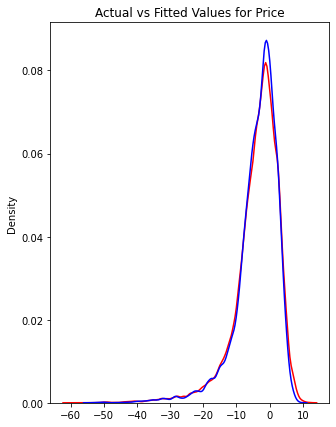

In [17]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(Y, hist=False, color="r", label="Actual Value")
sns.distplot(Y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Actual vs Fitted Values for Price')


plt.show()
plt.close()

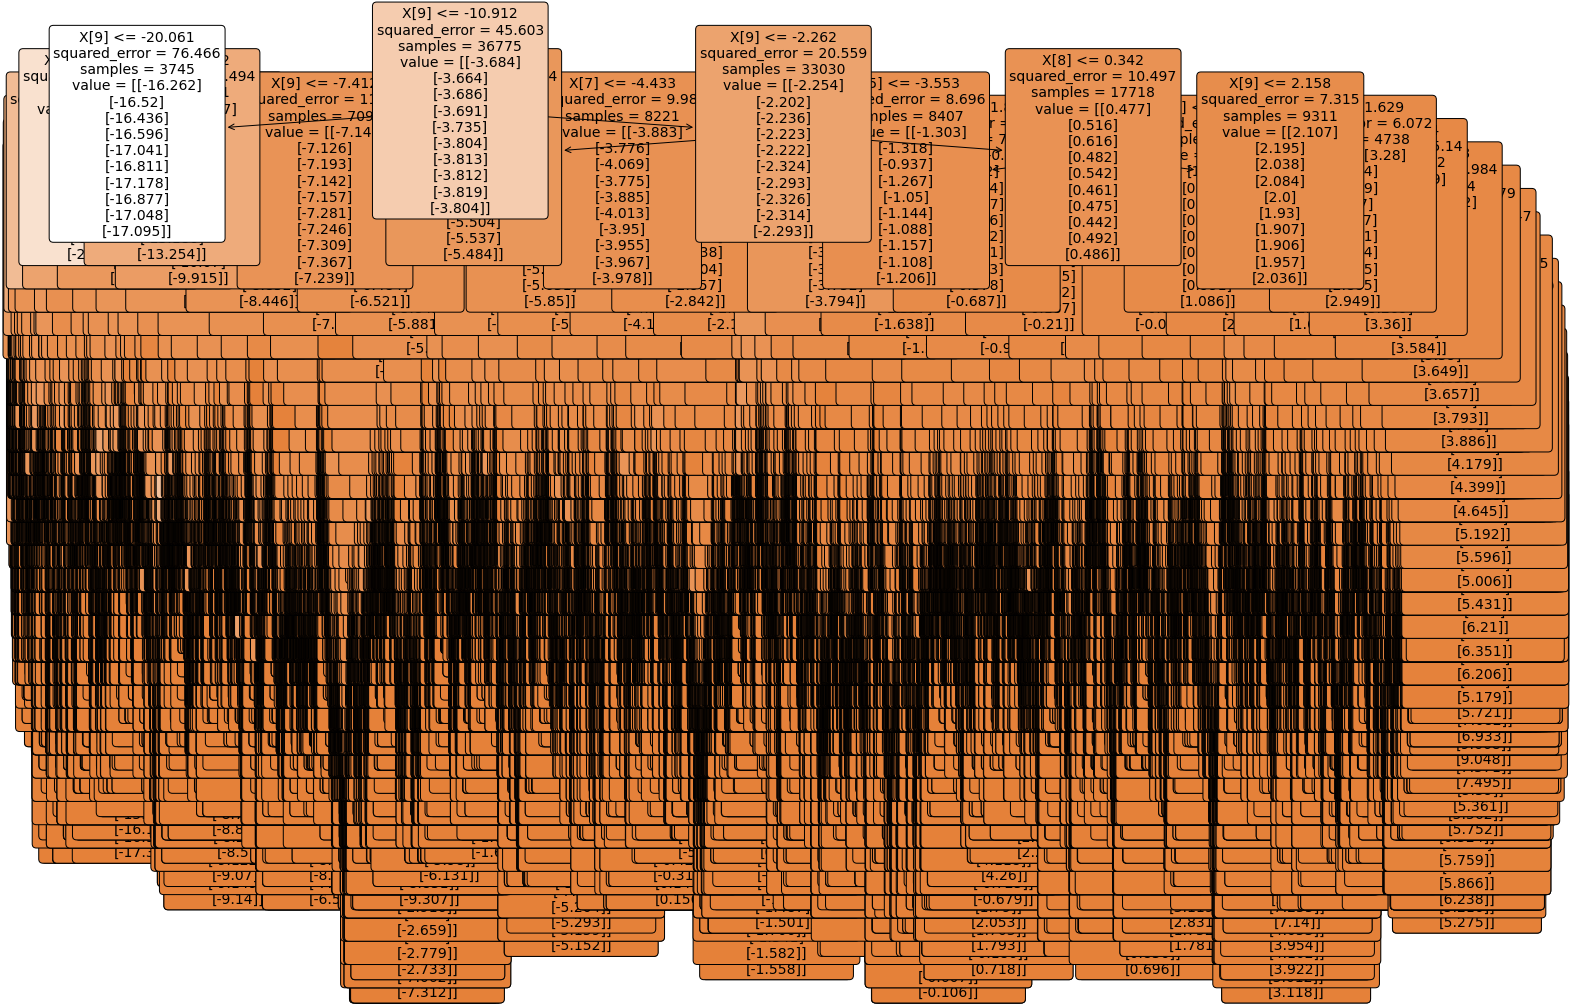

In [20]:
import pydot
# Pull out one tree from the forest
Tree = model.estimators_[5]
# Export the image to a dot file
from sklearn import tree
plt.figure(figsize=(25,15))
tree.plot_tree(Tree,filled=True, 
              rounded=True, 
              fontsize=14);

In [ ]:
##### Step 5 - Print Performance Summary

In [ ]:
print("")
print('-------------------- Model Summary --------------------')
model2.summary() # print model summary
print("")
print('-------------------- Weights and Biases --------------------')
print("Too many parameters to print but you can use the code provided if needed")
print("")
#for layer in model.layers:
#    print(layer.name)
#    for item in layer.get_weights():
#        print("  ", item)
#print("")

# Print the last value in the evaluation metrics contained within history file
print('-------------------- Evaluation on Training Data --------------------')
for item in history.history:
    print("Final", item, ":", history.history[item][-1])
print("")

# Evaluate the model on the test data using "evaluate"
print('-------------------- Evaluation on Test Data --------------------')
results = model2.evaluate(X_test, Y_test)
print("")